In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import os
import constants
import socket
from obspy.imaging.beachball import beachball
import argparse

In [16]:
def plot_distance_vs_displacement(df, event_ids, fit_type='attenuation'):
    try:
        # Set up a larger plot to prevent crowding
        plt.figure(figsize=(12, 8))

        # Loop over each event ID provided
        for event_id in event_ids:
            # Filter for the specific event ID
            event_data = df[df['Event ID'] == event_id]

            if event_data.empty:
                print(f"No data found for Event ID: {event_id}")
                continue

            # Ensure valid values for the plot (drop rows with NaN in required columns)
            valid_data = event_data.dropna(subset=['Distance from Epicenter', 'Displacement'])

            if valid_data.empty:
                print(f"No valid data for plotting distance vs displacement for Event ID: {event_id}")
                continue

            # Extract event magnitude for the legend
            magnitude = valid_data['Magnitude'].iloc[0]

            # Handle different fit types
            if fit_type == 'attenuation':
                # Log-transform Distance and Displacement for linear regression
                log_distance = np.log(valid_data['Distance from Epicenter'].values)
                log_displacement = np.log(valid_data['Displacement'].values)

                # Fit a linear regression model to log-transformed data
                model = LinearRegression()
                model.fit(log_distance.reshape(-1, 1), log_displacement)

                # Get the attenuation exponent n and log(A)
                n = -model.coef_[0]  # The slope of the line is -n
                log_A = model.intercept_  # The intercept gives log(A)
                A = np.exp(log_A)  # Convert log(A) back to A

                # Generate predicted displacements using the fitted n and A
                X_range = np.linspace(valid_data['Distance from Epicenter'].min(), valid_data['Distance from Epicenter'].max(), 500)
                y_pred = A * (X_range ** -n)

                # Plot the fitted attenuation curve
                plt.plot(X_range, y_pred, label=f"Attenuation Fit (M={magnitude}): Displacement = {A:.8f} * Distance^{{-{n:.8f}}}", linewidth=2)

            elif fit_type == 'polynomial':
                # Polynomial Regression (2nd degree)
                X = valid_data['Distance from Epicenter'].values.reshape(-1, 1)
                y = valid_data['Displacement'].values.reshape(-1, 1)

                # Apply 2nd-degree polynomial features to X
                poly = PolynomialFeatures(degree=2)
                X_poly = poly.fit_transform(X)

                # Fit the polynomial regression model
                poly_model = LinearRegression()
                poly_model.fit(X_poly, y)

                # Predict the displacement using the polynomial regression model
                X_range = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)  # Smooth line for better visualization
                X_poly_range = poly.transform(X_range)
                y_poly_pred = poly_model.predict(X_poly_range)

                # Get the polynomial coefficients for displaying the equation
                coef = poly_model.coef_[0]
                intercept = poly_model.intercept_[0]
                poly_formula = f"{coef[2]:.8f}x^2 + {coef[1]:.8f}x + {intercept:.8f}"

                # Plot the polynomial regression curve for this event
                plt.plot(X_range, y_poly_pred, label=f"Polynomial Fit (M={magnitude}): {poly_formula}", linewidth=2)

            # Also plot the original scatter data for this event
            plt.scatter(valid_data['Distance from Epicenter'], valid_data['Displacement'], label=f"Event {event_id} Data (M={magnitude})")

        # Add labels, title, and legend
        plt.xlabel('Distance from Epicenter (km)')
        plt.ylabel('Displacement (m)')
        plt.title(f'Distance vs Displacement with {fit_type.capitalize()} Fit')
        #plt.legend(loc='best')

        # Show the plot with all the fits on top of each other
        plt.tight_layout()  # Fix layout to avoid overlapping
        plt.show()

    except Exception as e:
        print(f"Error generating plot: {e}")

In [13]:
df = pd.read_csv('./geodesy_data/cleaned_combined_api_data.csv')

/var/folders/2q/0wssj_m1199_8dn42_d3j9lh0000gn/T/ipykernel_6435/1750399255.py:1: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./geodesy_data/cleaned_combined_api_data.csv')


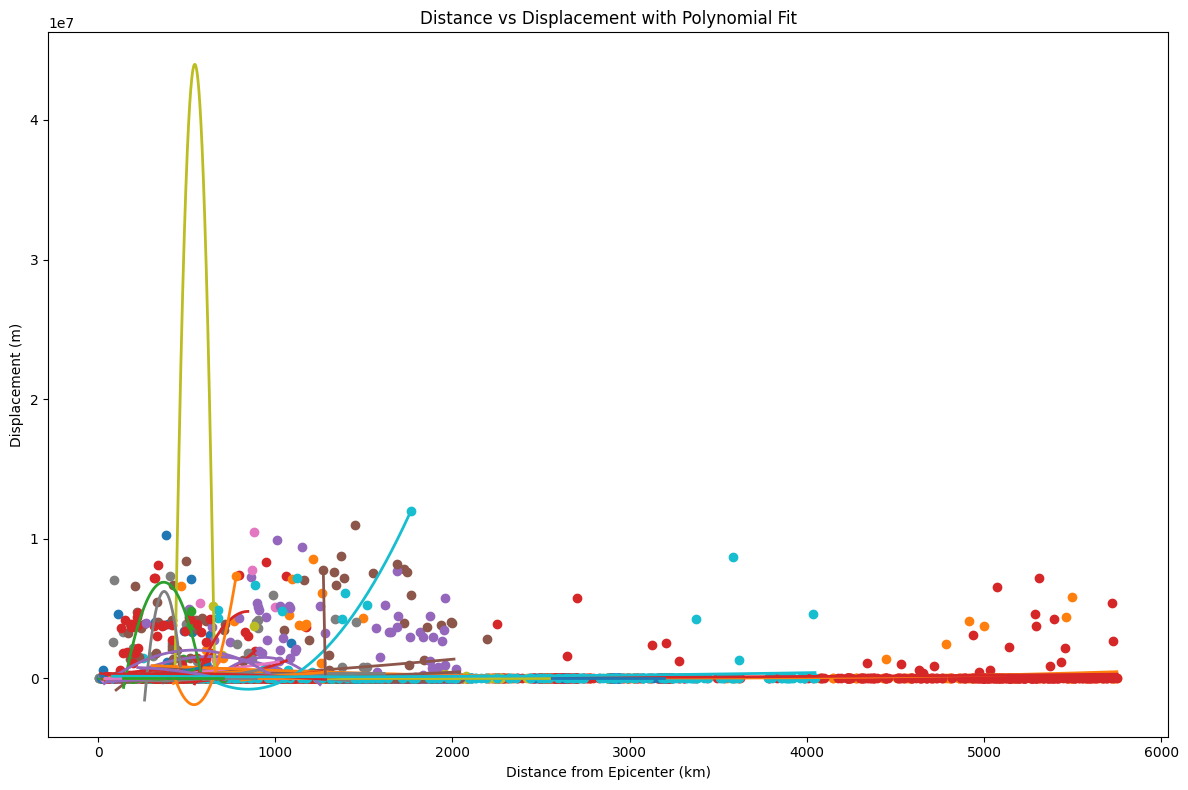

In [19]:
plot_distance_vs_displacement(df, df[df['Magnitude'] > 7]['Event ID'].unique(), fit_type='polynomial')